# Optimization Portfolio with Linear Programming


### 1. **Defining the Optimization Problem**

The goal of the optimization is to **maximize the portfolio return** based on the weights allocated to different cryptocurrencies. This is done using an optimization model. In this model:

- **Portfolio Return** is calculated as a function of the **allocation weights** to each cryptocurrency and their **average returns**.
- **Portfolio Risk** is calculated as a function of the **covariance matrix** between the assets (cryptocurrencies) and their allocation weights.

### 2. **Objective Function**

The main goal is to **maximize the portfolio return**. In other words, we are looking for allocation weights that maximize the portfolio's return. The objective function is defined as:


\begin{align}
\text{Portfolio Return} = \sum_{i} \text{Weight}_i \times \text{Average Return}_i
    \end{align}

Where:
\begin{align}
- \text{Weight}_i \text{ is the allocation percentage for } \text{cryptocurrency(i)}.
- \text{Average Return}_i \text{ is the weekly average return of } \text{cryptocurrency(i)}. \end{align}


To use `minimize` from the `scipy.optimize` library (which only minimizes the objective function), we negate this function in the code:

```python
def objective(weights):
    portfolio_return = np.sum(mean_returns * weights)
    return -portfolio_return  # Negative because we are minimizing
```

In this case, the `objective` function returns the negative of the portfolio return so that `minimize` can maximize it.

### 3. **Constraints**

To solve this optimization problem, we need to enforce a few constraints:

- The sum of all weights must equal 1, because the total allocation must be 100%. This constraint is defined as:

\begin{align}
\sum_{i} \text{Weight}_i = 1
 \end{align}


This constraint is implemented as:

```python
def constraint(weights):
    return np.sum(weights) - 1
```

- Additionally, each weight should be between 0 and 1 (no negative or over-100% allocations). Thus, the bounds for each cryptocurrency are set as:

```python
bounds = [(0, 1) for _ in range(num_assets)]
```

### 4. **Solving the Optimization Problem**

To find the optimal allocations, we use the **`scipy.optimize.minimize`** function. Here, the `minimize` function is used to minimize the objective function (negative portfolio return) while respecting the constraints:

```python
result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)
```

- `initial_weights` is used as the initial allocation, typically evenly distributed across assets.
- `bounds` specifies the constraints for the weights (between 0 and 1).
- `constraints` enforces the constraint that the sum of the weights must equal 1.

### 5. **Optimization Results**

After running the `minimize` function, the optimal allocation weights are stored in the variable `optimal_weights`. If the optimization is successful, these optimal weights are printed as percentages for each cryptocurrency:

```python
if result.success:
    optimal_weights = result.x
    print("\nOptimal Portfolio Weights:")
    for i in range(num_assets):
        print(f"{cryptos[i]}: {optimal_weights[i]:.2f}")
else:
    print("Optimization failed:", result.message)
```

### 6. **Calculating Portfolio Return and Risk**

After finding the optimal allocations, we can calculate the **portfolio return** and **portfolio risk**:

- **Portfolio Return** is computed by multiplying the optimal weights with the average returns:

\begin{align}
\text{Portfolio Return} = \sum_{i} \text{Weight}_i \times \text{Average Return}_i
\end{align}

- **Portfolio Risk** (which is the standard deviation of the portfolio) is calculated using the covariance matrix and the weights:

\begin{align}
\text{Portfolio Risk} = \sqrt{\text{Weight}^T \times \text{Covariance Matrix} \times \text{Weight}}
\end{align}

In the code:

```python
portfolio_return = np.sum(mean_returns * optimal_weights)
portfolio_risk = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
```

### 7. **Displaying Results**

Finally, after calculating the optimal weights, portfolio return, and risk, the results are displayed:

```python
print(f"\nExpected Portfolio Return: {portfolio_return:.4f}")
print(f"Portfolio Risk (Standard Deviation): {portfolio_risk:.4f}")
```

### Additional Explanation:

- **Optimization Objective**: The goal of this method is to find optimal allocations that maximize the portfolio return in the long run, while also managing the risk (volatility) of the portfolio. This is why the **covariance matrix** (which contains the correlations and variances between the assets) is used as a measure of risk.
- **Optimal Allocations**: The optimization helps determine what proportion of the portfolio each cryptocurrency should occupy. These allocations are chosen so that the portfolio return is maximized and risk is minimized at the same time.

### Conclusion

In this approach, optimal portfolio allocation is achieved through **linear programming** and **return optimization**, along with **risk constraints**. This model computes the optimal allocation for each cryptocurrency in your portfolio, balancing both risk and return in the most efficient way possible.

## Final code:

In [ ]:
pip install pycoingecko, numpy, pandas, matplotlib,scipy


First few rows of weekly returns:
             bitcoin  ethereum  binancecoin      tron
date                                                 
2023-11-26  0.033554  0.062567    -0.043249  0.055841
2023-12-03  0.044216  0.038300    -0.021266 -0.050617
2023-12-10  0.107995  0.081178     0.037624  0.032864
2023-12-17 -0.034253 -0.048327     0.026392 -0.036143
2023-12-24  0.035623  0.037263     0.110958  0.038896

Optimal Portfolio Weights:
bitcoin: 0.47
ethereum: 0.00
binancecoin: 0.53
tron: 0.00

Expected Portfolio Return: 0.0196
Portfolio Risk (Standard Deviation): 0.0594


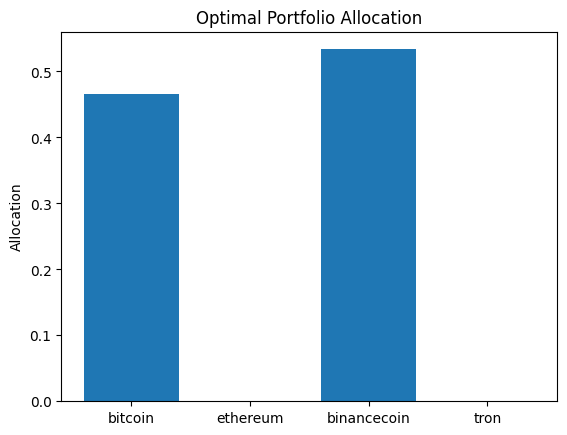

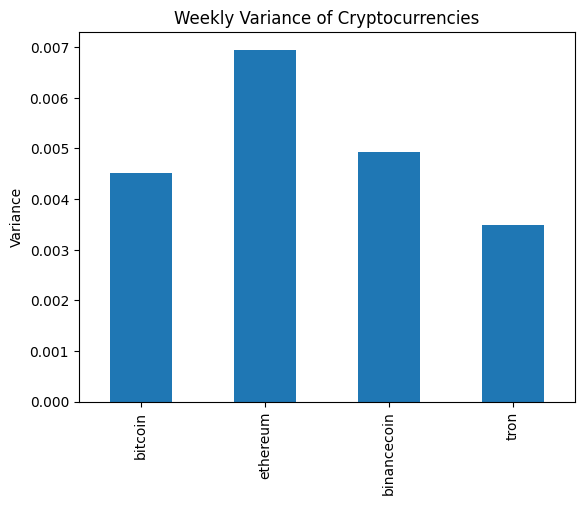

In [ ]:
import numpy as np
import pandas as pd
from pycoingecko import CoinGeckoAPI
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Run API CoinGecko
cg = CoinGeckoAPI()

# List of cryptocurrencies
cryptos = ['bitcoin', 'ethereum', 'binancecoin', 'tron']

# A recent year (API time limitation)
start_date = pd.to_datetime('today') - pd.DateOffset(years=1)
start_timestamp = int(start_date.timestamp())

# Today's date
end_date = pd.to_datetime('today')
end_timestamp = int(end_date.timestamp())

# Fetch prices of cryptocurrencies
def get_price_data(crypto_id, start_timestamp, end_timestamp):
    # Get historical data for currencies
    data = cg.get_coin_market_chart_range_by_id(id=crypto_id, vs_currency='usd',
                                                from_timestamp=start_timestamp,
                                                to_timestamp=end_timestamp)
    # Convert to DataFrame
    df = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('date', inplace=True)
    return df['price']

# Collect data for all currencies
data = pd.DataFrame()
for crypto in cryptos:
    data[crypto] = get_price_data(crypto, start_timestamp, end_timestamp)

# Convert daily data to weekly data
weekly_data = data.resample('W').last()  # Select the last price of the week

# Calculation of weekly returns
weekly_returns = weekly_data.pct_change().dropna()

# Display the first few rows of the weekly returns
print("\nFirst few rows of weekly returns:")
print(weekly_returns.head())

# Weekly variance calculation for each cryptocurrency
weekly_variance = weekly_returns.var()

# Calculation of correlation and variance matrix
cov_matrix = weekly_returns.cov()

# Calculation of average returns
mean_returns = weekly_returns.mean()

# Number of assets
num_assets = len(cryptos)

# Objective function: Maximize returns (based on allocations)
def objective(weights):
    # Portfolio return
    portfolio_return = np.sum(mean_returns * weights)
    return -portfolio_return  # Negative because we are minimizing

# Constraint: The sum of weights should equal 1
def constraint(weights):
    return np.sum(weights) - 1

# Constraints: Allocations must be positive
bounds = [(0, 1) for _ in range(num_assets)]

# Initial weights: evenly distributed
initial_weights = np.ones(num_assets) / num_assets

# Solving the optimization problem
constraints = ({'type': 'eq', 'fun': constraint})
result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)

# Displaying results
if result.success:
    optimal_weights = result.x
    print("\nOptimal Portfolio Weights:")
    for i in range(num_assets):
        print(f"{cryptos[i]}: {optimal_weights[i]:.2f}")
else:
    print("Optimization failed:", result.message)

# Calculate expected return and risk of the optimal portfolio
portfolio_return = np.sum(mean_returns * optimal_weights)
portfolio_risk = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))

print(f"\nExpected Portfolio Return: {portfolio_return:.4f}")
print(f"Portfolio Risk (Standard Deviation): {portfolio_risk:.4f}")

# Plotting the allocation chart
plt.bar(cryptos, optimal_weights)
plt.title('Optimal Portfolio Allocation')
plt.ylabel('Allocation')
plt.show()

# Plotting weekly variance for each cryptocurrency
weekly_variance.plot(kind='bar', title='Weekly Variance of Cryptocurrencies')
plt.ylabel('Variance')
plt.show()